# Melanoma Detection Assessment

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

## 1: Prerequisite



*   Importing Libraries
*   Load the images
*   Use Keras for preprocessing



In [7]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from glob import glob
import seaborn as sns

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from tensorflow.keras.preprocessing.image import load_img

In [8]:
!pip install Augmentor

In [9]:
import Augmentor

Mounting Google Drive


In [10]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Read from Google Drive

In [11]:
gdrive_location = "/content/gdrive/My Drive/Upgrad-EPGP-AIML/workspace/CNN_assignment"

In [12]:
data_dir_train = pathlib.Path(gdrive_location+"/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test =  pathlib.Path(gdrive_location+"/Skin cancer ISIC The International Skin Imaging Collaboration/Test")


Checking the image count

In [13]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


Use Keras for pre-processing

In [14]:
# Setting parameters
batch_size = 32
img_height = 180
img_width = 180

Train-Test data split (80-20)

In [15]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset='training',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


Define Validation Data set

In [16]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset='validation',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


Define Classess

In [17]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [18]:
len(class_names)

9

# 2: Data Visualisation

Visualising all the 9 classess

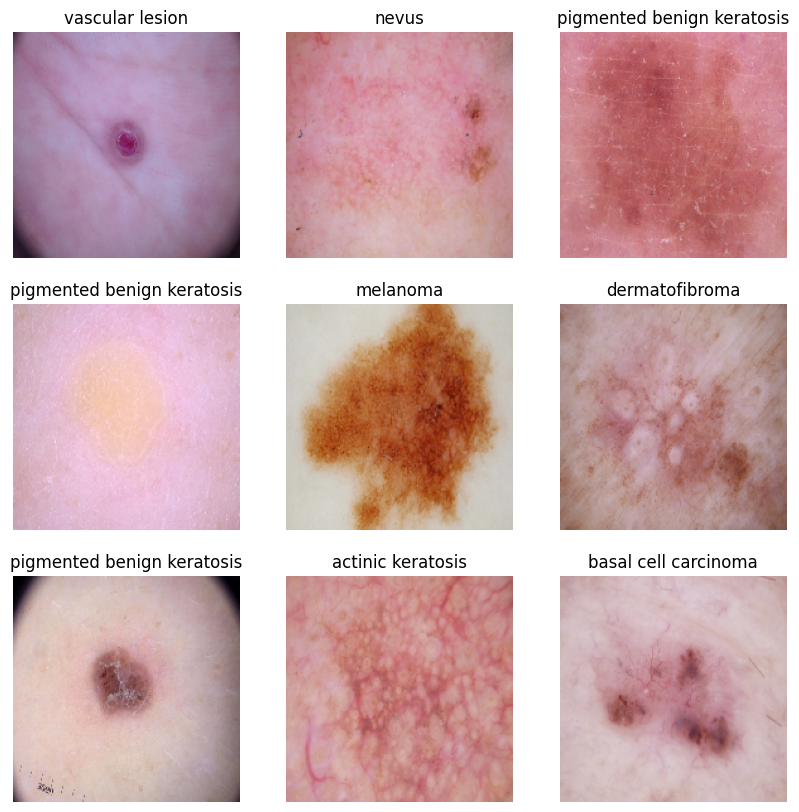

In [19]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [20]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# 3: Create the Model

 CNN model, which can accurately detect 9 classes present in the dataset. Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]

## 3.1 Define Model

In [21]:
target_labels = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation=tf.nn.relu),
  layers.Dense(target_labels)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## 3.2 Compile the model

In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

 Model Summary

In [23]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

## 3.3 Train the model

In [24]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 342s 2s/step - accuracy: 0.2459 - loss: 2.0168 - val_accuracy: 0.4698 - val_loss: 1.5637
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.4309 - loss: 1.5866 - val_accuracy: 0.4698 - val_loss: 1.4640
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.4683 - loss: 1.4780 - val_accuracy: 0.5436 - val_loss: 1.4603
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5232 - loss: 1.3495 - val_accuracy: 0.5391 - val_loss: 1.3419
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5964 - loss: 1.1887 - val_accuracy: 0.5570 - val_loss: 1.3890
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6124 - loss: 1.0931 - val_accuracy: 0.5280 - val_loss: 1.4187
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6670 - loss: 0.9604 - val_accuracy: 0.5034 - val_loss: 1.4975
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6654 - loss: 0.9623 - val_accuracy: 0.5570 - v

In [28]:
tf.keras.models.save_model(model, gdrive_location+"/model-1.keras")

## 3.4 Visualising training results

In [29]:
def visualize_data(epochs):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

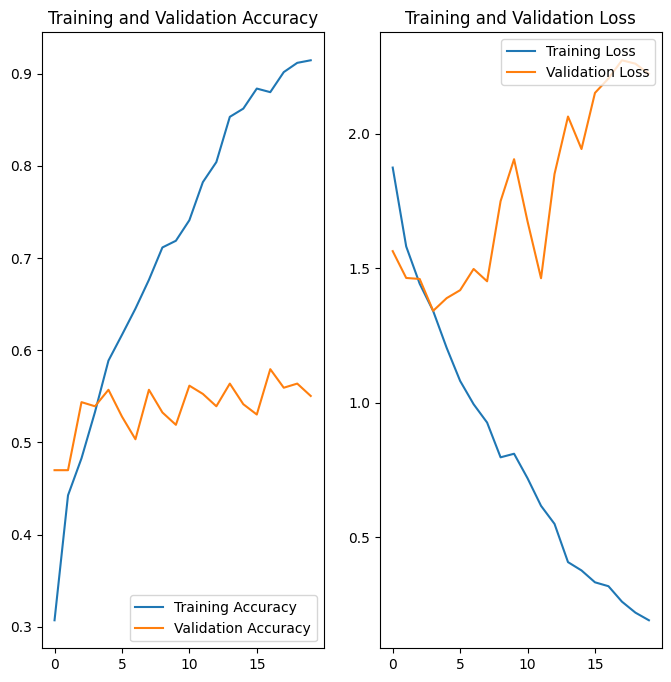

In [30]:
visualize_data(epochs)

## 3.5 Summary

- The model's training accuracy shows a steady increase of up to 90%, while the validation accuracy remains consistently around 55%.

- A high training accuracy suggests that the model has effectively captured the noise within the data. However, its poor performance on the validation data indicates a lack of generalizability.

- These observations confirm the presence of overfitting. To address this issue, augmentation techniques will be employed. Given the limited training data available, new samples will be generated by making slight modifications to existing data (such as horizontal/vertical image flipping, minor image rotations, etc.), which will then be used to train the model.


# 4. Update Model (After Augmentor)

## 4.1 Augmentor

In [31]:
augmentation_data = Sequential([
    layers.RandomFlip("horizontal",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

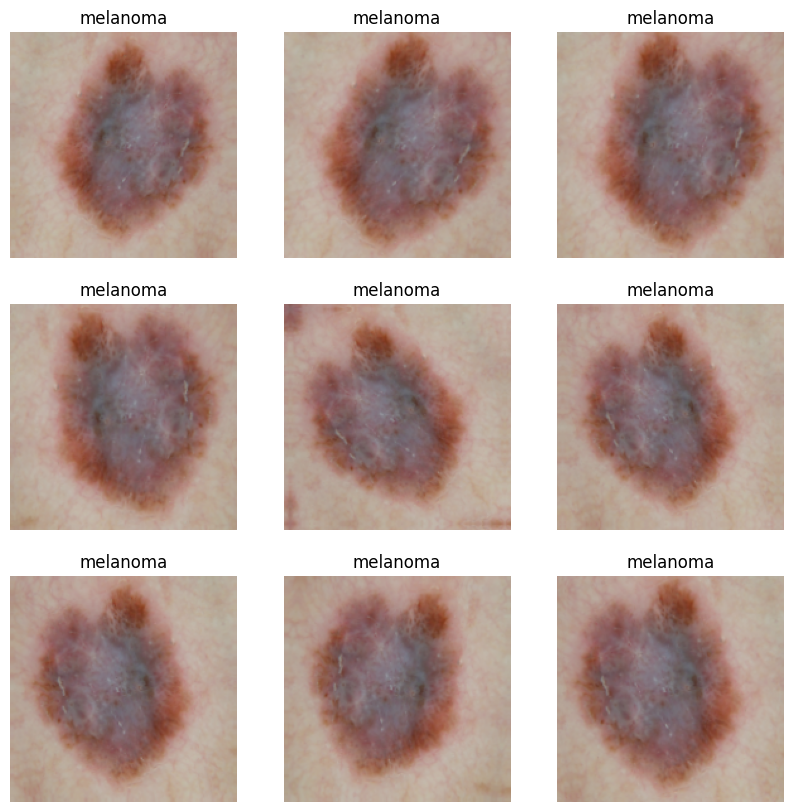

In [32]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        augmented_images = augmentation_data(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.title(class_names[labels[0]])
        plt.axis("off")

## 4.2 Define Model (With Augmented Data)

In [33]:
model = Sequential([
  augmentation_data,
  layers.Rescaling(1./255),
  layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation=tf.nn.relu),
  layers.Dense(target_labels)
])


## 4.3 Compiling

In [34]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## 4.4 Train the model

In [35]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.1812 - loss: 2.2595 - val_accuracy: 0.2058 - val_loss: 2.0009
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.2736 - loss: 1.9447 - val_accuracy: 0.3826 - val_loss: 1.8150
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.4252 - loss: 1.7008 - val_accuracy: 0.4430 - val_loss: 1.6209
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.5101 - loss: 1.4238 - val_accuracy: 0.4787 - val_loss: 1.4835
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.5170 - loss: 1.3843 - val_accuracy: 0.5078 - val_loss: 1.4257
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.5210 - loss: 1.3373 - val_accuracy: 0.5168 - val_loss: 1.4530
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.5152 - loss: 1.3603 - val_accuracy: 0.4787 - val_loss: 1.5008
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.4960 - loss: 1.3596 - val_accuracy: 0.5145 - v

In [36]:
tf.keras.models.save_model(model, gdrive_location+"/model-2.keras")

## 4.5 Validation

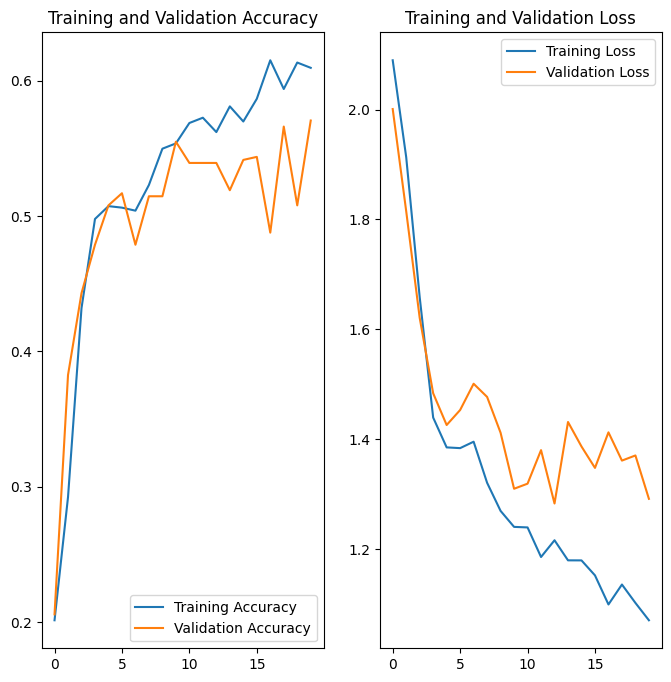

In [37]:
visualize_data(epochs)

## 4.6 Observartions

- By leveraging augmented data, overfitting has been effectively addressed.

- The training and validation accuracies of the aforementioned model now fall within a similar range.

- Both the training and validation performances are poor, indicating that the model is now exhibiting underfitting.



# 5: Check class Imbalance & Generate Image (Augmentor)

In [38]:

## find the image path for all class labels (lesions)
images_path_list = [ i for i in glob(os.path.join(data_dir_train, '*', '*.jpg')) ]

## Extract the class labels (lesions)
lesions_list = [ os.path.basename(os.path.dirname(j)) for j in glob(os.path.join(data_dir_train, '*', '*.jpg')) ]
print(len(lesions_list))

2239


In [39]:
# Extract image path and class label in a dictionary
image_dict = dict(zip(images_path_list, lesions_list))
print(list(image_dict.items())[:5])

[('/content/gdrive/My Drive/Upgrad-EPGP-AIML/workspace/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0026625.jpg', 'actinic keratosis'), ('/content/gdrive/My Drive/Upgrad-EPGP-AIML/workspace/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0025803.jpg', 'actinic keratosis'), ('/content/gdrive/My Drive/Upgrad-EPGP-AIML/workspace/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0026650.jpg', 'actinic keratosis'), ('/content/gdrive/My Drive/Upgrad-EPGP-AIML/workspace/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0026525.jpg', 'actinic keratosis'), ('/content/gdrive/My Drive/Upgrad-EPGP-AIML/workspace/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0025957.jpg', 'actinic keratosis')]


In [40]:
lesions_df = pd.DataFrame(list(image_dict.items()), columns=['Image Path', 'Label'])
lesions_df.head()

,Image Path,Label
0,/content/gdrive/My Drive/Upgrad-EPGP-AIML/work...,actinic keratosis
1,/content/gdrive/My Drive/Upgrad-EPGP-AIML/work...,actinic keratosis
2,/content/gdrive/My Drive/Upgrad-EPGP-AIML/work...,actinic keratosis
3,/content/gdrive/My Drive/Upgrad-EPGP-AIML/work...,actinic keratosis
4,/content/gdrive/My Drive/Upgrad-EPGP-AIML/work...,actinic keratosis


In [41]:
lesions_df[['Label']].value_counts()

,count
Label,
pigmented benign keratosis,462
melanoma,438
basal cell carcinoma,376
nevus,357
squamous cell carcinoma,181
vascular lesion,139
actinic keratosis,114
dermatofibroma,95
seborrheic keratosis,77


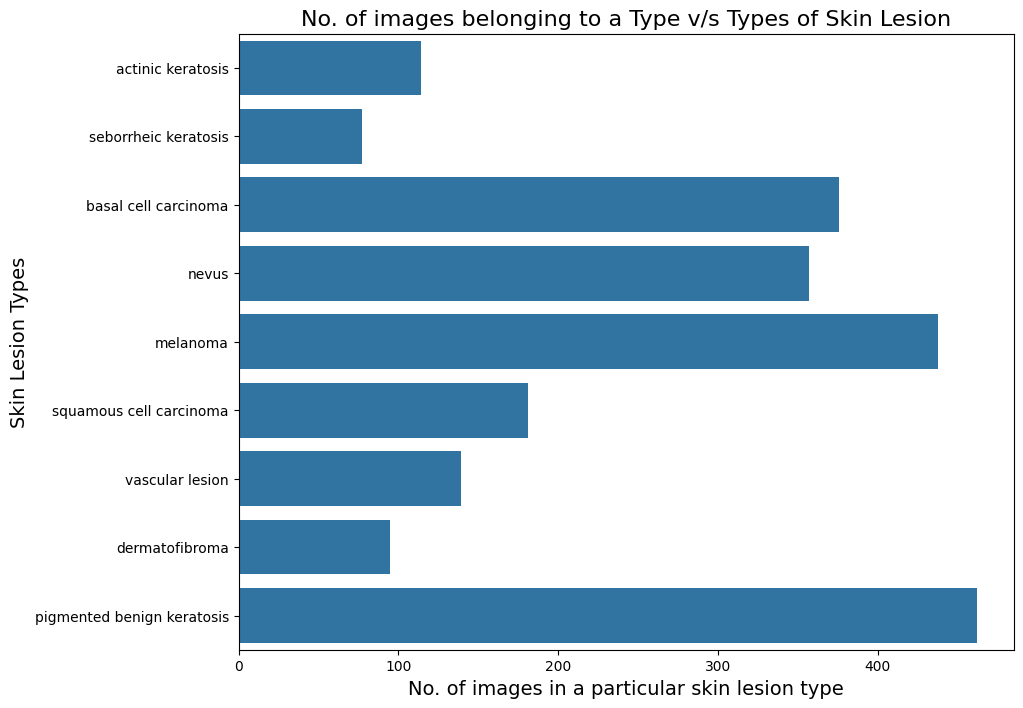

In [42]:
# Visualize the distribution of classes using a countplot

plt.figure(figsize=(10, 8))
sns.countplot(y="Label", data=lesions_df)
plt.title('No. of images belonging to a Type v/s Types of Skin Lesion', fontsize=16)
plt.xlabel('No. of images in a particular skin lesion type', fontsize=14)
plt.ylabel('Skin Lesion Types', fontsize=14)
plt.show()

## 5.1 Observations

- A clear class imbalance is evident in the training data.

- The class *seborrheic keratosis* represents the smallest proportion of samples, accounting for approximately 3.44%.

- *Pigmented benign keratosis* and "melanoma" significantly outnumber the other classes, representing approximately 20.63% and 19.56% of the data, respectively.

## 5.2 Train the model on the data created using Augmentor

In [43]:
path_to_training_dataset = str(data_dir_train) + '/'

for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    ## We are adding 500 samples per class to make sure that none of the classes are sparse.
    p.sample(500)

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/Upgrad-EPGP-AIML/workspace/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBA401C7250>: 100%|██████████| 500/500 [00:17<00:00, 28.96 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/Upgrad-EPGP-AIML/workspace/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBA401CC750>: 100%|██████████| 500/500 [00:18<00:00, 27.15 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/Upgrad-EPGP-AIML/workspace/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FBA4017AF50>: 100%|██████████| 500/500 [00:18<00:00, 27.06 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/Upgrad-EPGP-AIML/workspace/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FBA40192B50>: 100%|██████████| 500/500 [01:23<00:00,  6.00 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/Upgrad-EPGP-AIML/workspace/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7FBA406EF690>: 100%|██████████| 500/500 [01:15<00:00,  6.60 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/Upgrad-EPGP-AIML/workspace/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBA0B3EF8D0>: 100%|██████████| 500/500 [00:17<00:00, 28.75 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/Upgrad-EPGP-AIML/workspace/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FBA299F0D50>: 100%|██████████| 500/500 [00:40<00:00, 12.39 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/Upgrad-EPGP-AIML/workspace/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBA2990E9D0>: 100%|██████████| 500/500 [00:18<00:00, 27.62 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/Upgrad-EPGP-AIML/workspace/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FBA401C9650>: 100%|██████████| 500/500 [00:20<00:00, 24.80 Samples/s]


In [44]:
# Verifying the total count of images after the augmentation
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


## 5.3: Validating the train data set

In [45]:
# extracting the augmented image paths in a list
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))


In [46]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()), columns=['Image Path', 'Label'])
new_df = pd.concat([lesions_df, df2], ignore_index=True)
new_df.shape

(6739, 2)

In [47]:
# Inspecting the classes after adding 500 samples per label
new_df['Label'].value_counts()

,count
Label,
pigmented benign keratosis,962
melanoma,938
basal cell carcinoma,876
nevus,857
squamous cell carcinoma,681
vascular lesion,639
actinic keratosis,614
dermatofibroma,595
seborrheic keratosis,577


# 6. Create New Model (With updated train data)

In [48]:
batch_size = 32
img_height = 180
img_width = 180

## 6.1 Training data set

In [49]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


## 6.2 Validation data set

In [50]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


## 6.3 Create Model

In [64]:
model = Sequential([
  augmentation_data,
  layers.Rescaling(1./255),
  layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation=tf.nn.relu),
  layers.Dense(target_labels)
])

In [65]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_3 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

## 6.4 Compile Model

In [66]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
# ModelCheckpoint callback is employed alongside the model.fit() training process to periodically save the model
# or its weights (in a checkpoint file)
checkpoint = ModelCheckpoint("model.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)

# Early stop the training when a monitored metric ceases to show improvement
earlystop = EarlyStopping(monitor="val_accuracy", patience=8, mode="auto", verbose=1)

## 6.5 Train Model

In [67]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[checkpoint, earlystop]
)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.2175 - loss: 2.0714
Epoch 1: val_accuracy improved from -inf to 0.36154, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 43s 244ms/step - accuracy: 0.2179 - loss: 2.0701 - val_accuracy: 0.3615 - val_loss: 1.6679
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.3876 - loss: 1.6327
Epoch 2: val_accuracy improved from 0.36154 to 0.45212, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 248ms/step - accuracy: 0.3877 - loss: 1.6323 - val_accuracy: 0.4521 - val_loss: 1.4304
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.4654 - loss: 1.4187
Epoch 3: val_accuracy improved from 0.45212 to 0.48033, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 82s 247ms/step - accuracy: 0.4654 - loss: 1.4186 - val_accuracy: 0.4803 - val_loss: 1.3368
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.4892 - loss: 1.3339
Epoch 4: val_accuracy improved from 0.4

## 6.6. Validation

In [68]:
epoc = earlystop.stopped_epoch

0

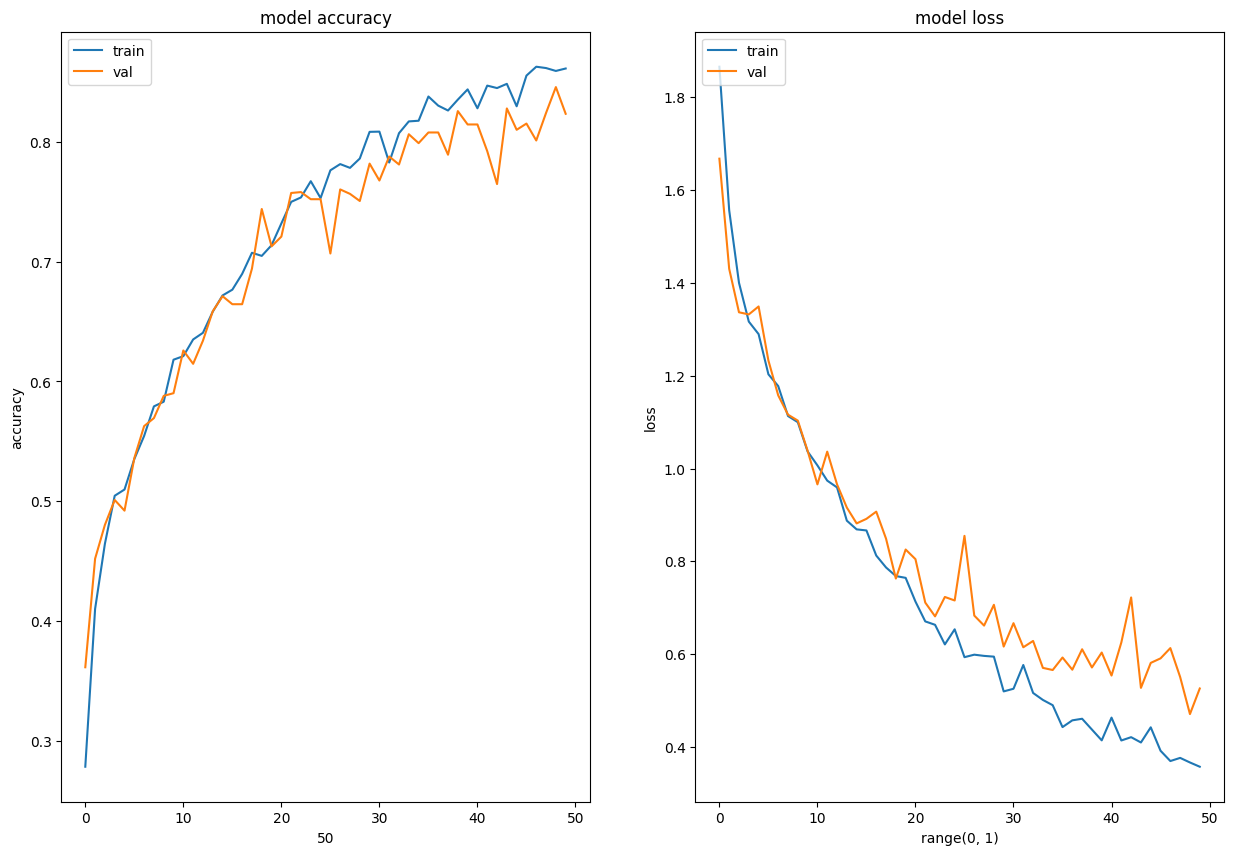

In [69]:
epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(50)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## 6.7 Observations

- The final model demonstrates well-balanced performance, with no evidence of underfitting or overfitting.

- Class rebalancing significantly improved model performance on both training and validation datasets.

- After 50 epochs (earlier early stop - 37 epochs), the final model achieved 87% accuracy on the training set and approximately 84% on the validation set.

- The small difference between training and validation accuracies highlights the strong generalization of the final CNN model.

## 6.8 Visualising the Model

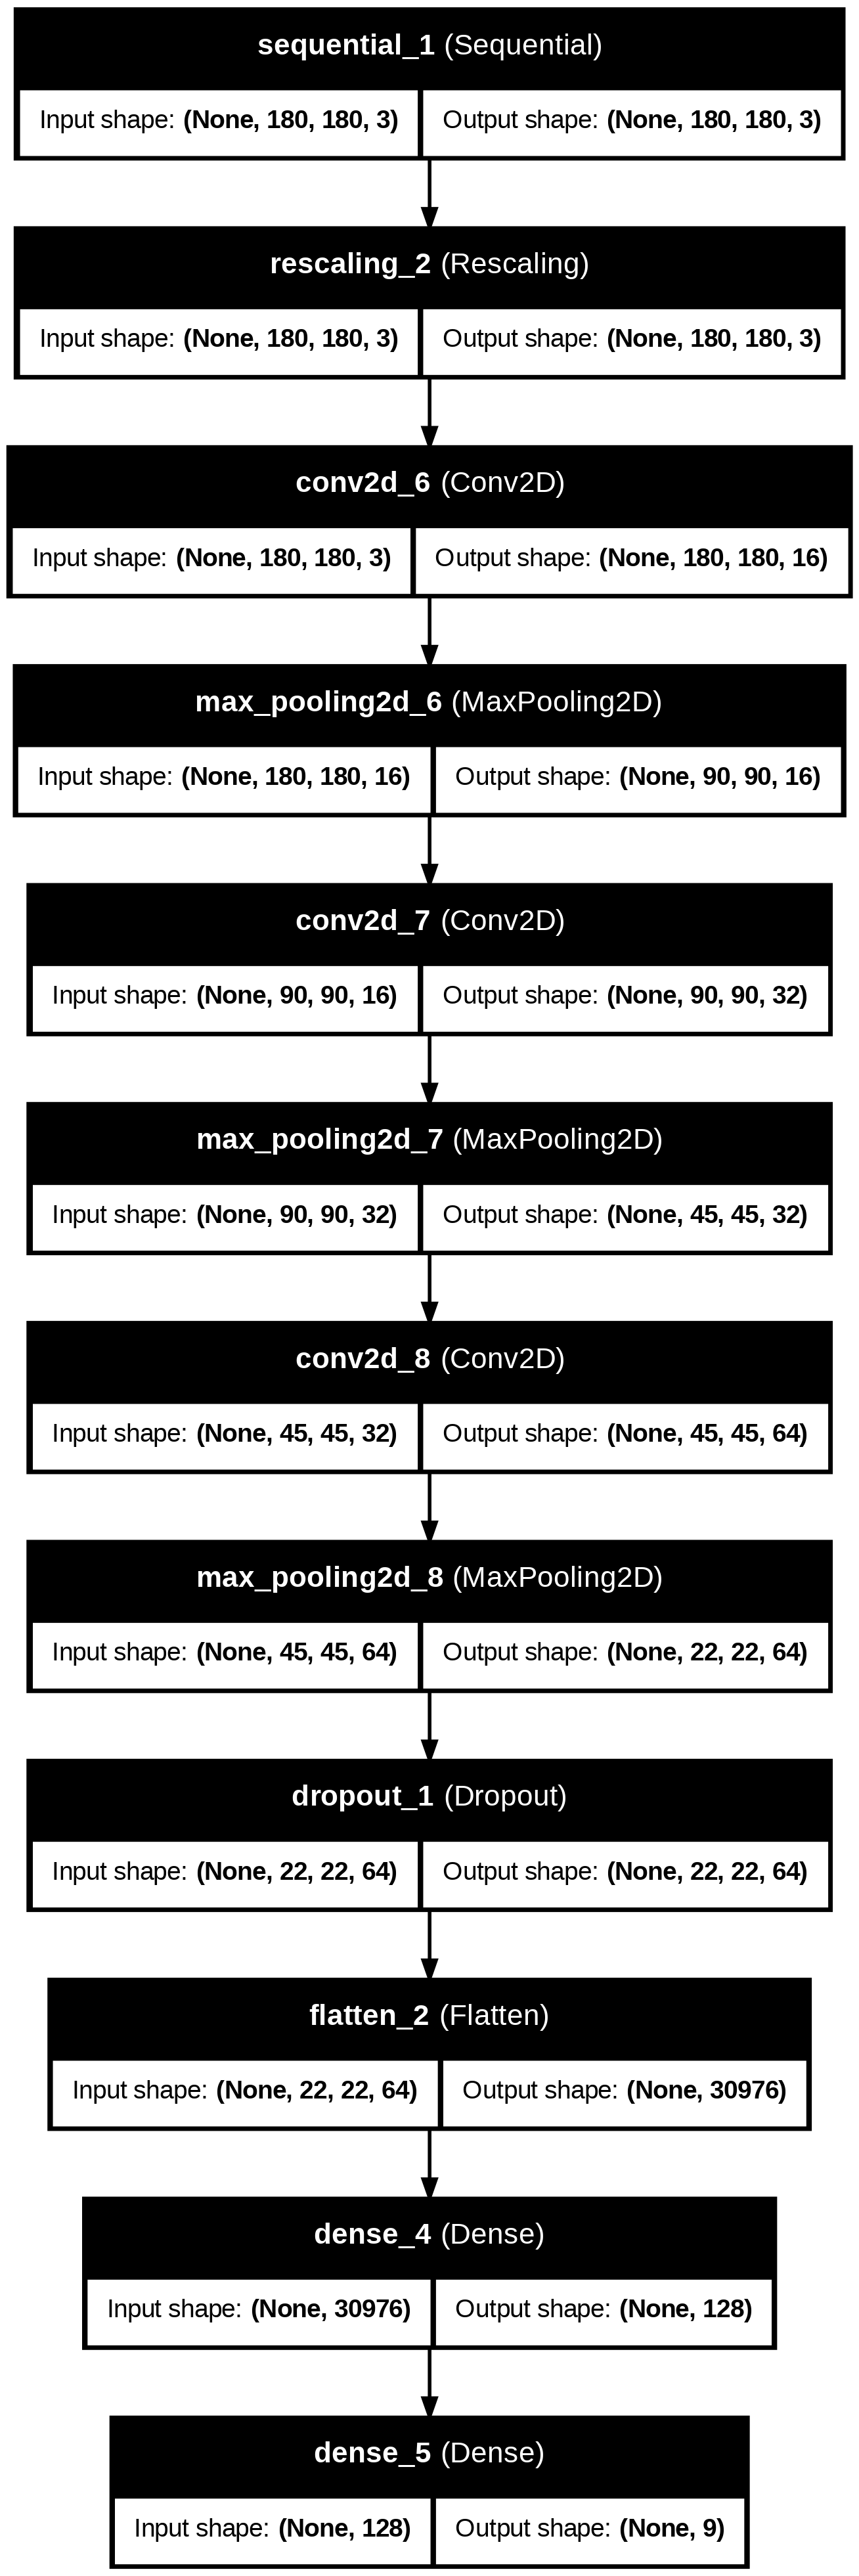

In [56]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## 6.9 Save the model

In [57]:
tf.keras.models.save_model(model, gdrive_location+"/final-model.keras")

# 7: Model Evaluation

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
Actual Class: basal cell carcinoma
Predicted Class: basal cell carcinoma


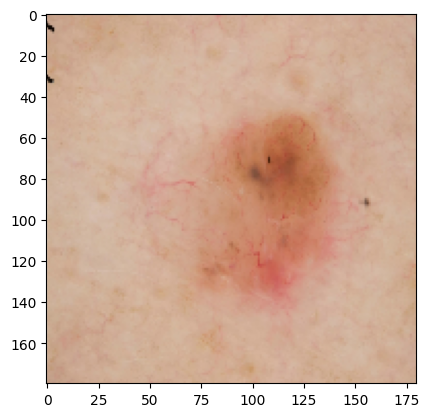

In [58]:
# Evaluating our model on one of the instances in the test set

image_path_test = os.path.join(data_dir_test, class_names[1], '*')
test_image = glob(image_path_test)
test_image = load_img(test_image[-1], target_size=(180, 180, 3))
plt.imshow(test_image)
plt.grid(False)

img = np.expand_dims(test_image, axis=0)
predicted = model.predict(img)
predicted = np.argmax(predicted)
predicted_class = class_names[predicted]
print("Actual Class: " + class_names[1] +'\n'+ "Predicted Class: " + predicted_class)

In [63]:
def evaluate_cnn_with_test_data(model_path, data_dir_test, img_height, img_width, batch_size):
    """
    Loads a CNN model and evaluates it on a test dataset.

    Args:
        model_path (str): Path to the saved Keras model.
        data_dir_test (str): Path to the directory containing the test images.
        img_height (int): Height of the input images.
        img_width (int): Width of the input images.
        batch_size (int): Batch size for the dataset.
    """

    try:
        # Load the model
        model = tf.keras.models.load_model(model_path)

        # Create the test dataset
        test_ds = tf.keras.preprocessing.image_dataset_from_directory(
            data_dir_test,
            seed=123,
            shuffle=False,
            image_size=(img_height, img_width),
            batch_size=batch_size
        )

        # Evaluate the model
        loss, accuracy = model.evaluate(test_ds)
        print(f"Test Loss: {loss:.4f}")
        print(f"Test Accuracy: {accuracy:.4f}")

    except FileNotFoundError:
        print(f"Error: Model or test data directory not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

model_path = gdrive_location+"/final-model.keras"
evaluate_cnn_with_test_data(model_path, data_dir_test, img_height, img_width, batch_size)

Found 118 files belonging to 9 classes.
4/4 ━━━━━━━━━━━━━━━━━━━━ 29s 8s/step - accuracy: 0.3395 - loss: 3.8818
Test Loss: 3.8333
Test Accuracy: 0.3983
